In [1]:
import numpy as np
import pandas as pd
import altair as alt
from sklearn.linear_model import LinearRegression
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.datasets import make_regression, load_boston
from sklearn.model_selection import train_test_split, cross_validate, GroupKFold
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn import metrics
from sklearn.metrics import make_scorer
from sklearn.model_selection import check_cv
import duplicate as dp
from functools import partial
import matplotlib.pyplot as plt


# https://altair-viz.github.io/user_guide/display_frontends.html#displaying-in-the-jupyter-notebook
# alt.renderers.enable('mimetype') # works off-line
# alt.renderers.enable('notebook') 
alt.renderers.enable('default') # recommended

RendererRegistry.enable('default')

In [2]:
# get bootstrap.py from parent directory
%cd ..
import bootstrap as bs
import reed as reed
%cd -

/Users/jack/Documents/GitHub/re-education
/Users/jack/Documents/GitHub/re-education/duplication


In [3]:
X, y = load_boston(return_X_y=True)
# X, y = make_regression(n_samples=1000,n_features=10, noise=.1, random_state=0)

feature_names = [f'X_{i}' for i in range(X.shape[1])]
data = pd.DataFrame(data=X, columns=feature_names)
data['y'] = y
# data.info()

/Users/jack/opt/anaconda3/envs/reed/lib/python3.9/site-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function load_boston is deprecated; `load_boston` is deprecated in 1.0 and will be removed in 1.2.

    The Boston housing prices dataset has an ethical problem. You can refer to
    the documentation of this function for further details.

    The scikit-learn maintainers therefore strongly discourage the use of this
    dataset unless the purpose of the code is to study and educate about
    ethical issues in data science and machine learning.

    In this case special case, you can fetch the dataset from the original
    source::

        import pandas as pd
        import numpy as np


        data_url = "http://lib.stat.cmu.edu/datasets/boston"
        raw_df = pd.read_csv(data_url, sep="\s+", skiprows=22, header=None)
        data = np.hstack([raw_df.values[::2, :], raw_df.values[1::2, :2]])
        target = raw_df.values[1::2, 2]

    Alternative datasets include the Ca

In [4]:
n_duplicates = 4
n_splits = 5
base_groups = np.arange(y.size)
X_train, X_test, y_train, y_test = train_test_split(X, y)
X_dup, y_dup, weights_dup, groups_dup = dp.simple_duplicate(X_train, y_train, n_duplicates)

scoring = {
    "MSE": make_scorer(metrics.mean_squared_error),
    "R2": make_scorer(metrics.r2_score),
}


In [5]:
# use custom CV with groups
# model = LinearRegression()
model = reed.StatsmodelsWLS()
# model = GridSearchCV(
#     # LinearRegression(),
#     GradientBoostingRegressor(random_state=0,),
#     # reed.StatsmodelsOLS(),
#     param_grid={},
#     cv=GroupKFold(n_splits=n_splits),
    
    
# )
# model_dup = LinearRegression()
model_dup = reed.StatsmodelsWLS()
# model_dup = GridSearchCV(
#     # LinearRegression(),
#     GradientBoostingRegressor(random_state=0),
#     # reed.StatsmodelsOLS(),
#     param_grid={}, 
#     cv=GroupKFold(n_splits=n_splits)
# )



def mean_var_cv_out(cv_out):
    means_vars = {}
    for k, v in cv_out.items():
        means_vars[k + "_mean"] = np.mean(v)
        means_vars[k + "_var"] = np.var(v)
    return means_vars


# mean_var_cv_out(output), mean_var_cv_out(output_dup)

# Train models, using bootstrapping

In [6]:
# use bootstrapping
def param_extractor(estimator):
    return estimator.get_params()

sample_weight= weights_dup


results = bs.bootstrap(
    estimator=model,
    X=X_train,
    y=y_train,
    error_score="raise",
    # groups=base_groups,
    parameter_extractor=param_extractor,
    return_estimator=True,
    groups=False,
    n_jobs=-1,
    sample_weight=sample_weight
)
print("Done un-duplicated")

results_dup = bs.bootstrap(
    estimator=model_dup,
    X=X_dup,
    y=y_dup,
    error_score="raise",
    # groups=groups_dup,
    parameter_extractor=param_extractor,
    return_estimator=True,
    n_jobs=-1,
    groups=False,
    sample_weight=sample_weight
)


# print(results['parameters'])

# print(scores)
# for score_dict in scores:
#     estimator = score_dict["estimator"]

Done un-duplicated


## Evaluate, compare models
Evaluate models on the (unduplicated) test data we set aside.

In [7]:
models = results['estimator']
models_dup = results_dup['estimator']

y_preds, y_preds_dup = ([model.predict(X_test) for model in ms] for ms in (models, models_dup))
y_preds, y_preds_dup = np.array(y_preds), np.array(y_preds_dup)




In [8]:

scores, scores_dup = (
    [metrics.mean_squared_error(y_pred, y_test) for y_pred in preds] 
    for preds in (y_preds, y_preds_dup)
    )

print(f"mean mse    : {np.mean(scores)}; mse var    : {np.var(scores)}")
print(f"mean dup mse: {np.mean(scores_dup)}; mse var dup: {np.var(scores_dup)}")

mean mse    : 27.592610819724936; mse var    : 4.816454897759112
mean dup mse: 26.56537051403817; mse var dup: 1.3961222332897139


In [9]:
# choose a representative sample using DBSCAN
from sklearn.cluster import DBSCAN
from sklearn.preprocessing import RobustScaler
from sklearn.decomposition import PCA
def find_representative_point_indices(X,y=None, max_num_points=-1, plot=False):
    """
    Get the indices of <max_num_points> representative points (found using DBSCAN algorithm).
    Arbitrarily selects min(max_num_points, num_core_points) core points.
    If max_num_points < 0, select all available core points
    """
    # combine [X, y] if required
    if y is None:
        if len(y.shape) == 1:
            y = y.reshape(-1,1)
        data =  np.hstack([X, y.reshape(-1,1)]) 
    else:
        data = X
    data = RobustScaler().fit_transform(data)
    data_2d = PCA(n_components=2, random_state=0).fit_transform(data)
    
    # cluster
    db = DBSCAN(eps=1).fit(data)
    core_indices = db.core_sample_indices_
    if plot: 
        plt.scatter(data_2d[:,0], data_2d[:,1])
        plt.scatter(data_2d[core_indices, 0], data_2d[core_indices,1], color='red', label="core point")
        plt.xlabel("$C_0$")
        plt.ylabel("$C_1$")
        plt.title("2 principal components")
        plt.legend()

    n_cores = len(core_indices)
    
    if n_cores < max_num_points:
        print(f"There are only {n_cores} representative points; choosing them")
    elif max_num_points > 0:
        core_indices = core_indices[:max_num_points]
    
    return core_indices

In [10]:


# take an arbitrary point in the test set; let's see how its performance changes:
core_indices = find_representative_point_indices(X_test, y_test, max_num_points=-1, plot=False)#[0]
index=core_indices[0]
point_y_hat = y_preds[:,index]
point_y_hat_dup = y_preds_dup[:, index]
point_y = y_test[index] * np.ones_like(point_y_hat)

point_data = pd.DataFrame(dict(
    point_y=point_y,
    point_y_hat=point_y_hat,
    point_y_hat_dup=point_y_hat_dup,
))

print(point_data.describe())



            point_y  point_y_hat  point_y_hat_dup
count  1.000000e+02   100.000000       100.000000
mean   2.120000e+01    23.576753        23.541952
std    7.141223e-15     0.489337         0.232735
min    2.120000e+01    22.213738        22.914580
25%    2.120000e+01    23.284979        23.380985
50%    2.120000e+01    23.569252        23.556615
75%    2.120000e+01    23.951313        23.728454
max    2.120000e+01    24.852626        23.958334


Observe (when the above models are WLS, and there are 4 duplicates used), that the point estimate's bootstrapped uncertainty goes down significantly; in particular, the true $y$ value is ~5 standard deviations away from the mean of the model trained with the duplicated data, up from ~2 stdev away from the mean of the model trained with un-duplicated data.

The uncertainty is increasing de

In [11]:
# Bootstrap parameter uncertainty comparison in linear regressor model

# get the <param_index> parameter of the 2 models
params, params_dup = ([model.coef_ for model in ms] for ms in (models, models_dup))
param_index = 0

param_i, param_i_dup = ([model_params[param_index] for model_params in ps] for ps in (params, params_dup))

print(
    f"param {param_index} mse: {metrics.mean_squared_error(param_i, param_i_dup)}",
    # f"mae: {metrics.mean_absolute_error(param_i, param_i_dup)}",
)



param 0 mse: 103.77543710238282


Text(0.5, 1.0, 'Duplicate vs unduplicate coefficient 0')

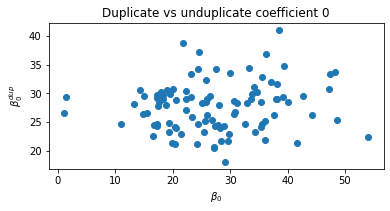

In [12]:
plt.scatter(param_i, param_i_dup)
plt.gca().set_aspect('equal')
plt.xlabel(f"$\\beta_{{{param_index}}}$")
plt.ylabel(f"$\\beta_{{{param_index}}}^{{dup}}$")
plt.title(f"Duplicate vs unduplicate coefficient {param_index}")
# plt.savefig('scatter_param.png')

Let's compare confidience intervals of a pair of WLS models

Text(0.5, 1.0, 'Parameter CIs: duplicate data')

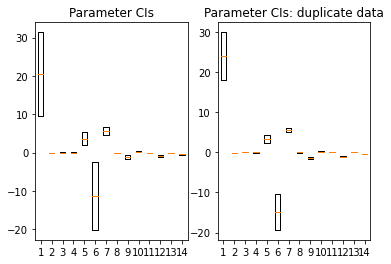

In [15]:
cis, cis_dup = models[0].conf_interval, models_dup[0].conf_interval
# print(ci, ci_dup)
bxpstats, bxpstats_dup = ([{
    "med": (ci[i,0]+ci[i,1])/2,  # TODO fix
    "q1": ci[i,0], # TODO fix
    "q3": ci[i,1], # TODO fix
    "whislo": ci[i, 0], 
    "whishi": ci[i, 1],
    # "fliers"
    } for i in range(len(cis))] for ci in (cis, cis_dup))
fig, ax = plt.subplots(1,2)
ax[0].bxp(bxpstats, showfliers=False)
ax[0].set_title("Parameter CIs")
ax[1].bxp(bxpstats_dup,showfliers=False)
ax[1].set_title("Parameter CIs: duplicate data")



- we see slightly more accurate estimates with substantially less variance in the errors when using the duplicated data
- TODO (after introducing econml model example so as to not prematurely harden the code?): wrap this up into a function that we can pass a model into.

# Visualise data

In [13]:
chart = alt.Chart(data).mark_point().encode(
    x='X_0',
    y='y',
    color='X_1:Q'
).properties(
    width=200,
    height=200
)

# un-comment to view
# chart

In [14]:
correlations = data.corr().stack().reset_index().rename(columns={0: 'correlation', 'level_0': 'variable 0', 'level_1': 'variable 1'})
# print(correlations.head())
corr_mat = alt.Chart(correlations).mark_rect().encode(
    x='variable 0:N',
    y='variable 1:N',
    color='correlation:Q'
).properties(
    width=200,
    height=200
)

combined_fig = alt.concat(
chart,
corr_mat
).resolve_scale(
    color='independent'
)

# un-comment to view
# combined_fig